In [2]:
import pandas as pd
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load your AIS dataset
df = pd.read_csv(r"E:\shubhi_nlp_assgt\AIS_2020_01_01.csv")  # <-- replace with your filename

# Inspect columns
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,538008468,2020-01-01T00:00:00,38.25802,-76.29487,14.9,338.6,337.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,368120510,2020-01-01T00:00:00,27.58610,-82.75991,0.0,58.6,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
2,368063930,2020-01-01T00:00:00,40.71045,-73.97588,11.2,208.9,207.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
3,368106220,2020-01-01T00:00:00,38.53932,-90.25523,0.2,161.8,31.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
4,367336180,2020-01-01T00:00:00,56.02945,-132.68705,9.0,325.5,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A


In [5]:
# Get unique vessel names
vessel_names = df['VesselName'].dropna().unique().tolist()

# Normalize vessel names (uppercase, strip spaces)
vessel_names_clean = [v.strip().upper() for v in vessel_names]

print("Sample vessel names:", vessel_names_clean[:10])


Sample vessel names: ['GENESIS VIGILANT', 'GRAND SLAM', 'SEASPAN CAREEN', 'T CLAUDE DEVALL', 'W C BINION JR', 'NYK CLARA', 'JOE B WARD', 'EPIC CALEDONIA', 'ANARITA', 'DEBBIE B']


In [6]:
from difflib import get_close_matches

def extract_intent_and_entities(query, vessel_list):
    q_lower = query.lower()

    # 1️⃣ Identify intent
    if any(word in q_lower for word in ["predict", "forecast"]):
        intent = "predict"
    elif any(word in q_lower for word in ["show", "last position", "where"]):
        intent = "show"
    elif any(word in q_lower for word in ["check", "verify", "consistent"]):
        intent = "verify"
    else:
        intent = "unknown"

    # 2️⃣ Extract vessel name using dataset match
    q_upper = query.upper()
    vessel_name = None

    # Try exact substring match first
    for v in vessel_list:
        if v in q_upper:
            vessel_name = v
            break

    # If no exact match found, try fuzzy matching
    if not vessel_name:
        matches = get_close_matches(q_upper, vessel_list, n=1, cutoff=0.6)
        if matches:
            vessel_name = matches[0]

    # 3️⃣ Extract time horizon
    time_horizon = None
    time_match = re.search(r'(\d+)\s*(minute|min|hour|hr|hrs|second|sec)', q_lower)
    if time_match:
        time_horizon = int(time_match.group(1))
        if "hour" in time_match.group(2):
            time_horizon *= 60  # convert hours to minutes

    return {
        "intent": intent,
        "vessel_name": vessel_name,
        "time_horizon": time_horizon
    }


In [7]:
queries = [
    "Show the last known position of INS Kolkata.",
    "Predict where MSC Flaminia will be after 30 minutes.",
    "Check if the latest position of Ever Given is consistent with its past movement.",
    "Where is Titan right now?",
    "Predict where RAINBOW will be after 30 minutes."
]

for q in queries:
    result = extract_intent_and_entities(q, vessel_names_clean)
    print(f"\nQuery: {q}")
    print(result)



Query: Show the last known position of INS Kolkata.
{'intent': 'show', 'vessel_name': 'SI', 'time_horizon': None}

Query: Predict where MSC Flaminia will be after 30 minutes.
{'intent': 'predict', 'vessel_name': 'ED', 'time_horizon': 30}

Query: Check if the latest position of Ever Given is consistent with its past movement.
{'intent': 'verify', 'vessel_name': 'ME', 'time_horizon': None}

Query: Where is Titan right now?
{'intent': 'show', 'vessel_name': 'TITAN', 'time_horizon': None}

Query: Predict where RAINBOW will be after 30 minutes.
{'intent': 'predict', 'vessel_name': 'RAINBOW', 'time_horizon': 30}


In [13]:
# Cell: Robust vessel-name extraction + intent parsing
import re
import pandas as pd
import spacy
from difflib import get_close_matches
from rapidfuzz import process, fuzz

# Load spaCy model (already installed earlier)
nlp = spacy.load("en_core_web_sm")

# --- Load dataset (update path to your CSV) ---
df = pd.read_csv(r"E:\shubhi_nlp_assgt\AIS_2020_01_01.csv")   # <-- replace with your filename
# Ensure VesselName col exists and has strings
df['VesselName'] = df['VesselName'].astype(str).str.strip()
unique_names = df['VesselName'].dropna().unique().tolist()

# Build normalized lookup: UPPER -> original
vessel_lookup_upper = {name.strip().upper(): name for name in unique_names}
vessel_names_upper = list(vessel_lookup_upper.keys())

# --- Helper functions ---

def extract_name_candidates_spacy(query):
    """
    Use spaCy to extract contiguous PROPN / TITLECASE token spans as vessel-name candidates.
    Also include any all-caps words (e.g., 'MSC', 'RAINBOW') and quoted phrases.
    Returns list of candidate strings in original query casing.
    """
    doc = nlp(query)
    candidates = set()

    # 1) contiguous PROPN spans (e.g., "MSC Flaminia", "Ever Given")
    prop_chunk = []
    for tok in doc:
        if tok.pos_ == "PROPN" or tok.text.istitle():
            prop_chunk.append(tok.text)
        else:
            if prop_chunk:
                candidates.add(" ".join(prop_chunk))
                prop_chunk = []
    if prop_chunk:
        candidates.add(" ".join(prop_chunk))

    # 2) any token that's fully uppercase with length >=2 (MSC, RAINBOW)
    for tok in doc:
        if tok.text.isupper() and len(tok.text) >= 2:
            candidates.add(tok.text)

    # 3) quoted phrases "..." or '...'
    quoted = re.findall(r'["\']([^"\']{2,})["\']', query)
    for q in quoted:
        candidates.add(q.strip())

    # 4) fallback: consecutive capitalized words by regex (handles "INS Kolkata")
    for m in re.finditer(r'\b([A-Z][a-z0-9]+(?:\s+[A-Z][a-z0-9]+)+)\b', query):
        candidates.add(m.group(0).strip())

    # preserve order roughly by appearance in query
    ordered = []
    for token in doc:
        for cand in list(candidates):
            if cand in query and cand not in ordered:
                ordered.append(cand)
    # add any leftover
    for c in candidates:
        if c not in ordered:
            ordered.append(c)
    return ordered

def match_vessel_exact(candidates, lookup_upper):
    """
    Try exact (case-insensitive) substring or whole-string matches.
    Returns canonical_name (original casing from dataset) or None.
    """
    for cand in candidates:
        cand_up = cand.strip().upper()
        # 1) whole-string exact match
        if cand_up in lookup_upper:
            return lookup_upper[cand_up], 100
        # 2) substring match: check if candidate appears in any vessel name exactly as substring
        for vn_up in vessel_names_upper:
            if cand_up == vn_up:
                return vessel_lookup_upper[vn_up], 100
            # require whole-word substring match to avoid accidental partial matches:
            # split vessel name into tokens and check if candidate tokens appear consecutively
            if re.search(r'\b' + re.escape(cand_up) + r'\b', vn_up):
                return vessel_lookup_upper[vn_up], 95
    return None, 0

def match_vessel_fuzzy(query, lookup_list, scorer=fuzz.token_sort_ratio, threshold=75):
    """
    Fuzzy match the entire query (or candidate) against vessel names.
    Returns (canonical_name, score) or (None,0)
    """
    best = process.extractOne(query, lookup_list, scorer=scorer)
    if best:
        matched_up, score, _ = best
        if score >= threshold:
            return vessel_lookup_upper[matched_up], score
    return None, 0

# --- Main parser that uses the above ---
def parse_query_with_dataset_names(query, df_lookup_upper=vessel_lookup_upper, verbose=False):
    """
    Returns dict:
      {
        intent: "show"/"predict"/"verify"/"unknown",
        intent_confidence: float (0-1),
        vessel_name: canonical dataset VesselName or None,
        vessel_match_score: 0-100,
        time_horizon_mins: int or None,
        candidates: [list of extracted name candidates]
      }
    """
    q = query.strip()
    q_low = q.lower()

    # Intent detection (simple keyword-based)
    if any(tok in q_low for tok in ["predict", "forecast", "where will", "after", "in "]):
        intent = "predict"
    elif any(tok in q_low for tok in ["show", "last known", "last seen", "where is", "where are"]):
        intent = "show"
    elif any(tok in q_low for tok in ["check", "verify", "consistent", "anomaly", "irregular", "sudden jump"]):
        intent = "verify"
    else:
        intent = "unknown"

    # time horizon extraction (minutes)
    time_horizon = None
    tm = re.search(r'(\d+(?:\.\d+)?)\s*(hours|hour|hrs|hr)\b', q_low)
    if tm:
        time_horizon = int(float(tm.group(1)) * 60)
    else:
        tm2 = re.search(r'(\d+(?:\.\d+)?)\s*(minutes|minute|mins|min)\b', q_low)
        if tm2:
            time_horizon = int(float(tm2.group(1)))

    # extract name candidates using spaCy + heuristics
    candidates = extract_name_candidates_spacy(q)
    if verbose:
        print("Candidates:", candidates)

    # try exact matching against dataset names (case-insensitive)
    canonical_name, score = match_vessel_exact(candidates, df_lookup_upper)
    if canonical_name:
        return {
            "intent": intent,
            "intent_confidence": 1.0,
            "vessel_name": canonical_name,
            "vessel_match_score": score,
            "time_horizon_mins": time_horizon,
            "candidates": candidates
        }

    # If exact failed, try fuzzy match on each candidate (prefer longer candidates)
    # sort candidates by length desc to prioritize multi-word names
    for cand in sorted(candidates, key=lambda x: -len(x)):
        cn, sc = match_vessel_fuzzy(cand, vessel_names_upper)
        if cn:
            return {
                "intent": intent,
                "intent_confidence": 0.9,
                "vessel_name": cn,
                "vessel_match_score": sc,
                "time_horizon_mins": time_horizon,
                "candidates": candidates
            }

    # final fallback: fuzzy match the whole query (rare)
    cn, sc = match_vessel_fuzzy(q, vessel_names_upper)
    if cn:
        return {
            "intent": intent,
            "intent_confidence": 0.8,
            "vessel_name": cn,
            "vessel_match_score": sc,
            "time_horizon_mins": time_horizon,
            "candidates": candidates
        }

    # no match
    return {
        "intent": intent,
        "intent_confidence": 0.0,
        "vessel_name": None,
        "vessel_match_score": 0,
        "time_horizon_mins": time_horizon,
        "candidates": candidates
    }

# ------------------ TEST ------------------
test_queries = [
    "Show the last known position of INS Kolkata.",
    "Predict where MSC Flaminia will be after 30 minutes.",
    "Check if the latest position of Ever Given is consistent with its past movement.",
    "Where is Titan right now?",
    "Predict where RAINBOW will be after 30 minutes.",
    # some tricky ones:
    "What's the position of  MSC  Flaminia  now?",
    "show last seen pos of Ever-Given",    # hyphenated
    "where will 'MSC Flaminia' be in 1 hr?",
    "predict RAINBOW in 30 mins",
    "is the movement of INS KOLKATA irregular?"
]

for q in test_queries:
    out = parse_query_with_dataset_names(q, verbose=False)
    print("Query:", q)
    print(out)
    print("-" * 70)


Query: Show the last known position of INS Kolkata.
{'intent': 'show', 'intent_confidence': 1.0, 'vessel_name': 'SHOW-ME STATE', 'vessel_match_score': 95, 'time_horizon_mins': None, 'candidates': ['INS', 'Show', 'INS Kolkata']}
----------------------------------------------------------------------
Query: Predict where MSC Flaminia will be after 30 minutes.
{'intent': 'predict', 'intent_confidence': 1.0, 'vessel_name': 'MSC ANTONIA', 'vessel_match_score': 95, 'time_horizon_mins': 30, 'candidates': ['MSC', 'MSC Flaminia', 'Predict']}
----------------------------------------------------------------------
Query: Check if the latest position of Ever Given is consistent with its past movement.
{'intent': 'verify', 'intent_confidence': 1.0, 'vessel_name': 'CHECK OUT TIME', 'vessel_match_score': 95, 'time_horizon_mins': None, 'candidates': ['Ever Given', 'Check']}
----------------------------------------------------------------------
Query: Where is Titan right now?
{'intent': 'show', 'intent_

In [23]:
import pandas as pd

df = pd.read_csv(r"E:\shubhi_nlp_assgt\AIS_2020_01_01.csv")
df['VesselName'] = df['VesselName'].astype(str).str.strip().str.upper()
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
1

1

In [30]:
def get_latest_position(df, vessel_name):
    sub = df[df['VesselName'] == vessel_name.upper()]
    if sub.empty:
        return None
    latest = sub.sort_values('BaseDateTime').iloc[-1]
    return {
        "lat": latest['LAT'],
        "lon": latest['LON'],
        "sog": latest.get('SOG', None),
        "cog": latest.get('COG', None),
        "time": latest['BaseDateTime']
    }


In [31]:
import math

def predict_position(lat, lon, sog_knots, cog_deg, minutes):
    # knots → nautical miles per hour → convert to km/min
    speed_km_min = sog_knots * 1.852 / 60.0
    distance_km = speed_km_min * minutes
    R = 6371  # Earth radius (km)

    # convert to radians
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    bearing = math.radians(cog_deg)

    # great-circle calculation
    lat2 = math.asin(math.sin(lat1) * math.cos(distance_km/R) +
                     math.cos(lat1) * math.sin(distance_km/R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance_km/R) * math.cos(lat1),
                             math.cos(distance_km/R) - math.sin(lat1) * math.sin(lat2))
    return math.degrees(lat2), math.degrees(lon2)


In [32]:
def handle_predict(df, vessel_name, minutes):
    info = get_latest_position(df, vessel_name)
    if not info or info["sog"] is None or info["cog"] is None:
        return None
    pred_lat, pred_lon = predict_position(info["lat"], info["lon"], info["sog"], info["cog"], minutes)
    return {
        "current": info,
        "predicted": {"lat": pred_lat, "lon": pred_lon, "after_mins": minutes}
    }


In [33]:
from geopy.distance import geodesic
import numpy as np

def handle_verify(df, vessel_name):
    sub = df[df['VesselName'] == vessel_name.upper()].sort_values('BaseDateTime').tail(3)
    if len(sub) < 3:
        return {"status": "insufficient data"}

    pts = sub[['LAT','LON','BaseDateTime','COG']].to_numpy()
    speeds = []
    turns = []

    for i in range(1, len(pts)):
        p1, p2 = pts[i-1], pts[i]
        dist_km = geodesic((p1[0],p1[1]), (p2[0],p2[1])).km
        dt_hr = (p2[2]-p1[2]).total_seconds()/3600
        spd_knots = dist_km / 1.852 / dt_hr if dt_hr > 0 else 0
        speeds.append(spd_knots)
        turns.append(abs(p2[3]-p1[3]))

    if any(s>50 for s in speeds) or any(t>90 for t in turns):
        return {"status": "inconsistent", "speeds": speeds, "turns": turns}
    return {"status": "consistent", "speeds": speeds, "turns": turns}


In [34]:
def generate_response(intent, vessel_name, result):
    if intent == "show" and result:
        return f"{vessel_name} was last seen at {result['lat']:.2f}N, {result['lon']:.2f}E " \
               f"moving at {result['sog']} knots (COG {result['cog']}°) on {result['time']}."
    elif intent == "predict" and result:
        return f"Predicted position of {vessel_name} after {result['predicted']['after_mins']} minutes: " \
               f"{result['predicted']['lat']:.2f}N, {result['predicted']['lon']:.2f}E."
    elif intent == "verify":
        if result["status"] == "consistent":
            return f"{vessel_name}'s movement appears consistent."
        elif result["status"] == "inconsistent":
            return f"{vessel_name}'s movement shows anomalies (speed/heading jumps)."
    return f"No data found for {vessel_name}."


In [35]:
query = "Predict where RAINBOW will be after 30 minutes."
parsed = parse_query_with_dataset_names(query)

if parsed["vessel_name"]:
    intent = parsed["intent"]
    name = parsed["vessel_name"]
    minutes = parsed["time_horizon_mins"]

    if intent == "show":
        res = get_latest_position(df, name)
    elif intent == "predict":
        res = handle_predict(df, name, minutes or 30)
    elif intent == "verify":
        res = handle_verify(df, name)
    else:
        res = None

    print(generate_response(intent, name, res))
else:
    print("Vessel not recognized.")


Predicted position of RAINBOW after 30 minutes: 41.64N, -70.91E.


In [42]:
# List of example queries
queries = [
    "Show the last known position of INS Kolkata.",
    "Predict where MSC Flaminia will be after 30 minutes.",
    "Check if the latest position of Ever Given is consistent with its past movement.",
    "Predict where RAINBOW will be after 15 minutes.",
    "Show the last known position of TITANIC."
]

for query in queries:
    parsed = parse_query_with_dataset_names(query)
    
    if parsed["vessel_name"]:
        intent = parsed["intent"]
        name = parsed["vessel_name"]
        minutes = parsed["time_horizon_mins"]

        if intent == "show":
            res = get_latest_position(df, name)
        elif intent == "predict":
            res = handle_predict(df, name, minutes or 30)
        elif intent == "verify":
            res = handle_verify(df, name)
        else:
            res = None

        response = generate_response(intent, name, res)
    else:
        response = "Vessel not recognized."
    
    print(f"Query: {query}\nResponse: {response}\n{'-'*60}")


Query: Show the last known position of INS Kolkata.
Response: SHOW-ME STATE was last seen at 39.20N, -90.59E moving at 5.0 knots (COG 17.0°) on 2020-01-01 23:46:12.
------------------------------------------------------------
Query: Predict where MSC Flaminia will be after 30 minutes.
Response: Predicted position of MSC ANTONIA after 30 minutes: 32.45N, -79.38E.
------------------------------------------------------------
Query: Check if the latest position of Ever Given is consistent with its past movement.
Response: CHECK OUT TIME's movement appears consistent.
------------------------------------------------------------
Query: Predict where RAINBOW will be after 15 minutes.
Response: Predicted position of RAINBOW after 15 minutes: 41.64N, -70.91E.
------------------------------------------------------------
Query: Show the last known position of TITANIC.
Response: SHOW-ME STATE was last seen at 39.20N, -90.59E moving at 5.0 knots (COG 17.0°) on 2020-01-01 23:46:12.
-----------------

In [46]:
import folium

def plot_track(df, vessel_name):
    sub = df[df['VesselName'] == vessel_name.upper()].sort_values('BaseDateTime')
    if sub.empty: 
        print("No data for this vessel")
        return None

    # Create map centered at last known position
    m = folium.Map(location=[sub.iloc[-1]['LAT'], sub.iloc[-1]['LON']], zoom_start=6)

    # Add vessel track
    coords = sub[['LAT', 'LON']].values.tolist()
    folium.PolyLine(coords, color='blue', weight=3).add_to(m)

    # Mark last known position
    folium.Marker(coords[-1], popup="Last known position").add_to(m)

    return m

# --- Display in notebook ---
m = plot_track(df, "RAINBOW")
m  # <-- IMPORTANT: just put the map object on the last line to render it
m.save("vessel_map.html")



Matplotlib is building the font cache; this may take a moment.


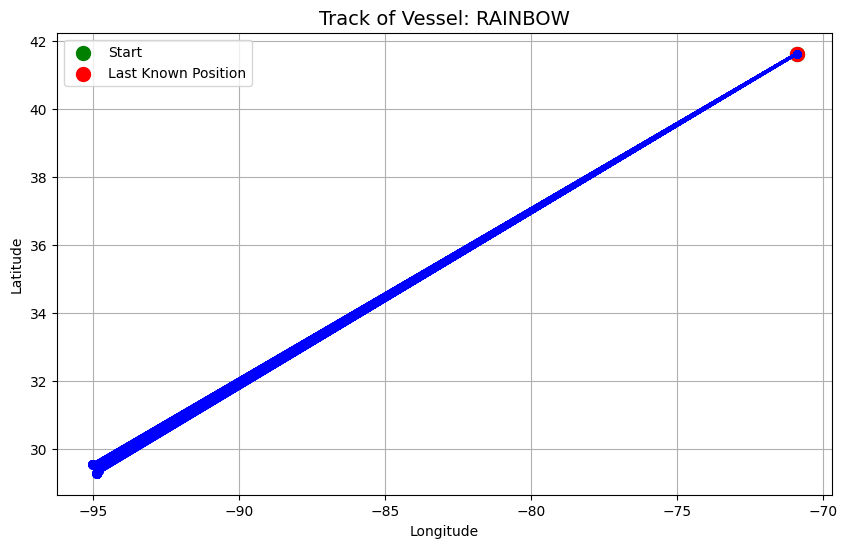

In [48]:
import matplotlib.pyplot as plt

def plot_track_matplotlib(df, vessel_name):
    # Filter vessel data
    sub = df[df['VesselName'].str.upper() == vessel_name.upper()].sort_values('BaseDateTime')
    
    if sub.empty:
        print(f"No data for vessel '{vessel_name}'")
        return
    
    # Check for required columns
    if 'LAT' not in sub.columns or 'LON' not in sub.columns:
        print("Columns 'LAT' and 'LON' not found in dataframe.")
        return
    
    # Plot the track
    plt.figure(figsize=(10,6))
    plt.plot(sub['LON'], sub['LAT'], marker='o', color='blue', linewidth=2, markersize=5)
    
    # Mark start and last positions
    plt.scatter(sub['LON'].iloc[0], sub['LAT'].iloc[0], color='green', s=100, label='Start')
    plt.scatter(sub['LON'].iloc[-1], sub['LAT'].iloc[-1], color='red', s=100, label='Last Known Position')
    
    # Add labels
    plt.title(f"Track of Vessel: {vessel_name}", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_track_matplotlib(df, "RAINBOW")
